## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [89]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://gconfusion_matrixcom/Greenstand/Tree_Species/tree/master/training)).

In [90]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.47.48_18.29019017983228_-73.5579...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...


In [91]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
        
def image_saver(df):
    try:
        urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
        return True
    except:
        return False
    
        
# image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data["saved"] = data.apply(image_saver, axis=1)
print (data[data["saved"]].shape[0], " images saved out of ", data.shape[0])

710  images saved out of  772


710  total valid samples
Class breakdown
{'ACACAURI': 130, 'ANACOCCI': 86, 'CATALONG': 100, 'CEDRODOR': 113, 'MANGINDI': 221, 'SIMAGLAU': 60}
6  classes found


Text(0.5, 1.0, 'Count per class')

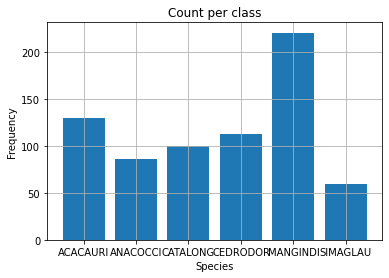

In [92]:
data = data[data["saved"]]
print (data.shape[0], " total valid samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [93]:
arrs = []
labels = []
import logging 
# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((299, 299)))
            labels.append(species)
            


## Visualize a few images


Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median', 'f', 'laplace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


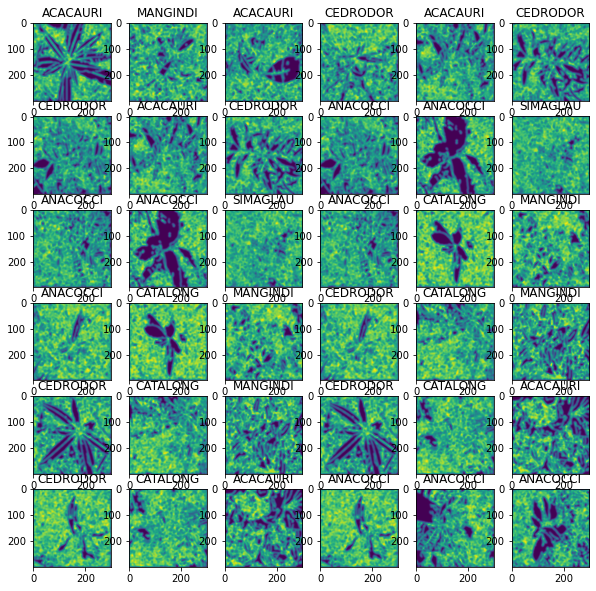

In [94]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import feature
from skimage.color import rgb2gray
from skimage.filters import * 
n_imgs = 36
idxs = np.random.choice(np.arange(0, len(arrs)), replace=False, size=n_imgs)
f, axarr = plt.subplots(6, 6, figsize=(10 ,10))

preprocessing = lambda img: gaussian(feature.canny(rgb2gray(np.array(img)), sigma=1), 3)
preprocess = []
for i in range(6):
    for j in range(6):
        img = np.array(arrs[idx])[:, :, 1]
        idx = idxs[i * 3 + j]
        # axarr[i, j].imshow(feature.canny(rgb2gray(np.array(arrs[idx]))))
        axarr[i, j].imshow(preprocessing(img))
        axarr[i, j].set_title(labels[idx])
plt.show()
    

In [95]:
X = np.vstack([preprocessing(img).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

Explained variation per principal component: [13.99854449  3.27726314  2.56898466  1.95173601  1.70075119  1.63370437
  1.35395942  1.25956466  1.06057259  1.03761913  0.97739444  0.9178592
  0.89224438  0.84608628  0.77818303  0.76520168  0.74297206  0.71324965
  0.68872319  0.65844929  0.63813871  0.61976329  0.60275334  0.59189108
  0.55909723  0.55116855  0.53962284  0.5241851   0.51568975  0.5082483
  0.49264155  0.47439032  0.47160255  0.44490198  0.43167515  0.42800629
  0.4246442   0.41518986  0.40403577  0.39651884  0.39098568  0.37738458
  0.37638005  0.37325488  0.36576565  0.36016591  0.35730813  0.34669452
  0.3386109   0.33117005]
51.474947931253354 % variance explained total


In [96]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [97]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  3.952192  4.744809  ACACAURI    0.0
1  2.990470  3.753206  ACACAURI    0.0
2  5.533341  0.553904  ACACAURI    0.0
3 -2.140951 -0.155612  ACACAURI    0.0
4 -5.518088 -2.005954  ACACAURI    0.0


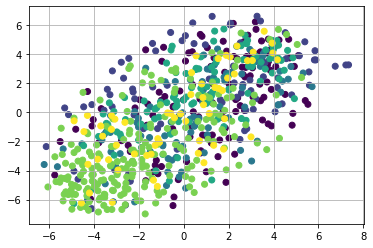

In [98]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


In [99]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [100]:
val_split = 0.3
num_epochs = 1000

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

transform = T.Compose([T.Resize(512), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.RandomRotation(degrees=90),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(), 
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])


tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [101]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def predictor_helper(df):
    path =  os.path.join(savepath, df["class"], df["imname"])
    img = Image.open(path)
    preprocess = T.Compose([
        T.Resize(299),
        T.CenterCrop(299),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    inception.eval()
    with torch.no_grad():
        output = inception(input_batch)
    return output.squeeze().numpy()

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
data['fv'] = data.apply(predictor_helper, axis=1)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
inception.train()
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, weight_decay=1e-5)



Device:  cuda:0


92.24534034729004 % variance explained total


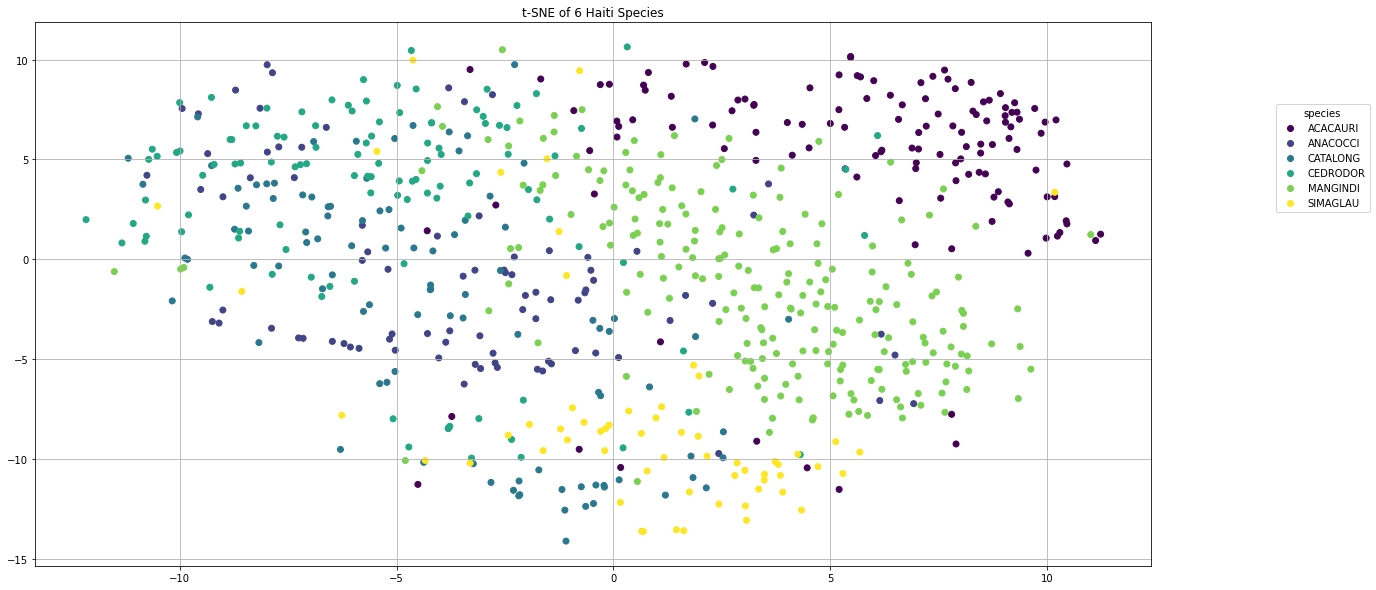

In [144]:
inception_stack = np.vstack([fv for fv in data['fv'].values])
pca = PCA(n_components=100)
X_red = pca.fit_transform(inception_stack)
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")
inception_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=20.0, n_iter=15000).fit_transform(X_red)
tsne_inception_result = pd.DataFrame(inception_embedded)
tsne_inception_result["class"] = labels
tsne_inception_result.columns = ["x0", "x1", "class"]

# Make figure
f = plt.figure(figsize=(20, 10))
scatter = plt.scatter(tsne_inception_result["x0"], tsne_inception_result["x1"], c=tsne_inception_result["class"].astype('category').cat.codes)
plt.title("t-SNE of %d Haiti Species"%num_classes)
plt.grid()
plt.legend(handles=scatter.legend_elements()[0],
           labels=list(tsne_inception_result["class"].astype('category').cat.categories),
           title="species",
           bbox_to_anchor=(1.2,0.75),
           loc='right')
plt.show()

In [87]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
4  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
5  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  saved  \
0  https://treetracker-production-images.s3.eu-ce...   True   
1  https://treetracker-production-images.s3.eu-ce...   True   
2  https://treetracker-production-images.s3.eu-ce...   True   
4  https://treetracker-production-images.s3.eu-ce...   True   
5  https://treetracker-production-images.s3.eu-ce...   True   

                                                  fv  
0  [1.5039421, 1.5022854, -0.8888605, -0.07126953...  
1  [-0.23153915, -0.28790194, -0.54753953, 0.1399...  
2  [0.88553905, -0.53466284, -0.2032216, 0.542013...  
4  [

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    tr_samples = 0
    n_tr_batches = 0
    for batch_x, batch_y in tr_dataloader:
        n_tr_batches += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        tr_samples += batch_y.size()[0]
    cf_matx = None
    with torch.no_grad():
        n_val_batches = 0
        val_samples = 0
        running_val_loss = 0
        val_acc_sum = 0
        for val_x, val_y in val_dataloader:
            n_val_batches += 1
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            running_val_loss += val_loss.item()
            preds = torch.argmax(val_output.logits, dim=1)
            val_acc_sum += torch.sum(preds == val_y) # wrote this way just in case there's batched validation
            val_samples += val_y.size()[0]
            cf_matx = confusion_matrix(preds.detach().cpu().numpy(), val_y.detach().cpu().numpy())
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
    print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
    print ("Confusion matrix:")
    print (cf_matx)
    print ("=" * 40)
print ("Finished training")

Epoch 1 finished in 37.508613 seconds
Training/Validation Loss per Batch: 1.651090/ 1.533464
Training/Validation Accuracy (percent): 30.516432 /30.382292
Confusion matrix:
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 92  62  75  82 151  35]
 [  0   0   0   0   0   0]]
Epoch 2 finished in 27.563577 seconds
Training/Validation Loss per Batch: 1.496393/ 1.384406
Training/Validation Accuracy (percent): 32.863850 /31.790743
Confusion matrix:
[[  7   0   3   0   1   1]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   1   0   0]
 [ 85  62  72  81 150  34]
 [  0   0   0   0   0   0]]
Epoch 3 finished in 27.795135 seconds
Training/Validation Loss per Batch: 1.352322/ 1.347785
Training/Validation Accuracy (percent): 38.497654 /36.820923
Confusion matrix:
[[  3   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  4   2   8  34   5   7]
 [ 85  60  67  48 146  28]
 [  0   0   0   0   0  